In [ ]:
import os
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader
from torchvision import models, transforms
from torchvision.datasets import MNIST
from torchvision.utils import save_image, make_grid
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation, PillowWriter
import numpy as np
import matplotlib.pyplot as plt
import scipy as sp
from time import perf_counter
from functools import partial
import multiprocessing
from numba import jit
from sklearn.linear_model import LogisticRegression

### ***기본 세팅을 위한 함수 및 변수 설정***

In [3]:
L = 40
N = 5000
beta = 1

g_w = 1

b = np.random.normal(0.0,g_w/np.sqrt(L),L)
w = np.random.normal(0.0,g_w/np.sqrt(L),(L,L))

In [ ]:
def compute_energy(s, h, J):
    h_tensor = torch.from_numpy(h).to(s.device).float()
    J_tensor = torch.from_numpy(J).to(s.device).float()

    E_h = -torch.matmul(s, h_tensor)
    E_J = -torch.einsum('bi,ij,bj->b', s, J_tensor, s) / 2

    return (E_h + E_J).detach().cpu().numpy() 

def plot_energy_histogram(E_mcmc, E_diff_cond, E_diff_cond2, E_diff_null, num):
    save_dir="figures"
    filename=f"energy_histogram_{num}.png"
    os.makedirs(save_dir, exist_ok=True)
    
    plt.figure(figsize=(8,6))
    plt.hist(E_mcmc, bins=50, alpha=0.5, label='MCMC', density=True)
    plt.hist(E_diff_cond, bins=50, alpha=0.5, label='Diffusion (freq)', density=True)
    plt.hist(E_diff_cond2, bins=50, alpha=0.5, label='Diffusion (rare)', density=True)
    plt.hist(E_diff_null, bins=50, alpha=0.5, label='Diffusion (uncond)', density=True)
    plt.xlabel("Energy")
    plt.ylabel("Density")
    plt.legend()
    
    # 저장
    save_path = os.path.join(save_dir, filename)
    plt.savefig(save_path, dpi=300)
    plt.close() 

    print(f"✅ Histogram saved at: {save_path}")

In [ ]:
def inverse_ising_logistic(data):
    """
    data: M x n numpy array of spin configurations (+1 or -1)
    Returns: biases b (n,), coupling matrix W (n x n)
    """
    M, n = data.shape
    W = np.zeros((n, n))
    b = np.zeros(n)

    for i in range(n):
        y = data[:, i]

        X = np.delete(data, i, axis=1)

        y_binary = (y + 1) // 2

        clf = LogisticRegression(penalty='l2', solver='lbfgs')
        clf.fit(X, y_binary)

        b[i] = clf.intercept_[0] / 2.0
        w_i = clf.coef_[0] / 2.0
        W[i, np.arange(n) != i] = w_i

    W = (W + W.T) / 2.0
    return b, W

def mse(w, w_e, b, b_e) :
    LL = 40 + 40*(40-1)/2
    b_error = np.sum((b_e - b)**2)/LL
    mask = np.triu(np.ones_like(w), k=1)
    w_diff = (w_e - w) * mask
    w_error = np.sum(w_diff**2)/LL
    return (b_error + w_error)

### ***에너지 분포를 기반으로 한 데이터 생성 및 cfg 모델 트레이닝***

In [ ]:
# ------------------------------
# 1. MCMC 데이터 생성 (Ising Model)
# ------------------------------
N = 40
L = 5000
b = np.random.normal(0.0,g_w/np.sqrt(40),40)
w = np.random.normal(0.0,g_w/np.sqrt(40),(40,40))
h = b
J = w


J = (J + J.T) / 2

def MCMC(L, N, h, J):
    seq = np.random.choice([+1, -1], N)
    samples = np.zeros((L, N))
    for l in range(L*100):
        i = np.random.randint(0, N)
        dE = 2*seq[i]*(h[i]+np.dot(J[i,:],seq))
        if dE < 0 or np.random.rand() < np.exp(-dE):
            seq[i] = -seq[i]
        if l % 100 == 0:
            samples[l//100] = seq
    return samples

s = MCMC(L, N, h, J)

In [ ]:
np.save("new_s.npy", s)
np.save("b.npy", h)
np.save("w.npy", J)
b = h
w = J

In [ ]:
s = np.load("ising_samples.npy ")
h = np.load("ising_h.npy")
w = np.load("ising_w.npy")
b = h
J = w

In [ ]:
def compute_energy_torch(samples, b, w):
    # energy = -b·σ - sum_{i<j} w_ij σ_i σ_j
    field_term = -torch.matmul(samples, b)
    interaction_term = -0.5 * torch.sum(samples @ w * samples, dim=1)
    return field_term + interaction_term

def estimate_f_epsilon_torch(samples, b, w, epsilon):
    with torch.no_grad():
        energies = compute_energy_torch(samples, b, w)
        ps = torch.exp(-energies)
        ps_epsilon = ps ** (-1 + epsilon)
        weights = ps_epsilon / ps_epsilon.sum()
    return weights

def update_parameters_torch(samples, b, w, epsilon, lr):
    weights = estimate_f_epsilon_torch(samples, b, w, epsilon)

    mean_sigma = torch.sum(weights[:, None] * samples, dim=0)

    outer = samples.unsqueeze(2) * samples.unsqueeze(1)  # shape: (N, L, L)
    weighted_outer = weights[:, None, None] * outer
    mean_sigma_sigma = torch.sum(weighted_outer, dim=0)
    mean_sigma_sigma.fill_diagonal_(0.0)

    b_model = epsilon * b
    w_model = epsilon * w

    b_new = b + lr * (mean_sigma - b_model)
    w_new = w + lr * (mean_sigma_sigma - w_model)

    return b_new, w_new

def train_erasure_machine_torch(samples_np, n, epsilon=0.05, lr=0.1, epochs=100, use_cuda=True):
    device = torch.device("cuda" if use_cuda and torch.cuda.is_available() else "cpu")
    samples = torch.tensor(samples_np, dtype=torch.float32, device=device)

    b = torch.randn(n, device=device) * 0.01
    w = torch.randn(n, n, device=device) * 0.01
    w = (w + w.T) / 2
    w.fill_diagonal_(0.0)

    for epoch in range(epochs):
        b, w = update_parameters_torch(samples, b, w, epsilon, lr)
        if epoch % 10 == 0:
            print(f"[GPU] Epoch {epoch}: b norm = {b.norm():.4f}, w norm = {w.norm():.4f}")
    return b.cpu().numpy(), w.cpu().numpy()

def run_erasure_machine(samples, epsilon=0.6, lr=0.1, epochs=150):
    n = samples.shape[1]
    b_learned, w_learned = train_erasure_machine_torch(samples, n, epsilon=epsilon, lr=lr, epochs=epochs)
    return b_learned, w_learned

L = 40
def mse(w, w_e, b, b_e) :
    LL = L + L*(L-1)/2
    b_error = np.sum((b_e - b)**2)/LL
    mask = np.triu(np.ones_like(w), k=1)
    w_diff = (w_e - w) * mask
    w_error = np.sum(w_diff**2)/LL
    return (b_error + w_error)


b_new, w_new = run_erasure_machine(s)
mse_error = mse(w_new, w, b_new, b)
print(f"Mean Squared Error: {mse_error:.4f}")

[GPU] Epoch 0: b norm = 0.1578, w norm = 0.6463
[GPU] Epoch 10: b norm = 0.7047, w norm = 2.9731
[GPU] Epoch 20: b norm = 0.8992, w norm = 3.8553
[GPU] Epoch 30: b norm = 0.9884, w norm = 4.2606
[GPU] Epoch 40: b norm = 1.0314, w norm = 4.4552
[GPU] Epoch 50: b norm = 1.0525, w norm = 4.5501
[GPU] Epoch 60: b norm = 1.0630, w norm = 4.5968
[GPU] Epoch 70: b norm = 1.0682, w norm = 4.6200
[GPU] Epoch 80: b norm = 1.0709, w norm = 4.6315
[GPU] Epoch 90: b norm = 1.0722, w norm = 4.6372
[GPU] Epoch 100: b norm = 1.0728, w norm = 4.6401
[GPU] Epoch 110: b norm = 1.0732, w norm = 4.6416
[GPU] Epoch 120: b norm = 1.0734, w norm = 4.6423
[GPU] Epoch 130: b norm = 1.0734, w norm = 4.6427
[GPU] Epoch 140: b norm = 1.0735, w norm = 4.6429
Mean Squared Error: 0.0022


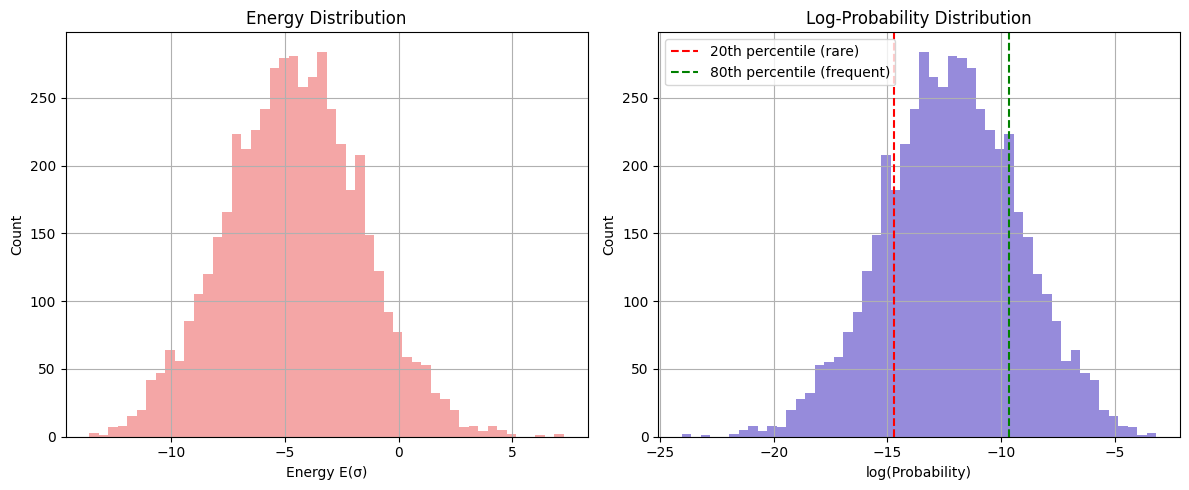

In [34]:
import matplotlib.pyplot as plt
L, N = s.shape
energies = np.array([-np.dot(s[i], h) - np.dot(s[i], J @ s[i]) for i in range(L)])
probs = np.exp(-energies)
probs /= probs.sum()

percentile_80 = np.percentile(probs, 80)
percentile_20 = np.percentile(probs, 20)

y = np.full(L, 2, dtype=int)  # 중간은 2
y[probs < percentile_20] = 1  # rare
y[probs > percentile_80] = 0  # frequent

x0 = torch.from_numpy(s).float()
y = torch.from_numpy(y)

mask = (y != 2)
x0_filtered = x0[mask]
y_filtered = y[mask]
import matplotlib.pyplot as plt
import numpy as np
log_probs = np.log(probs)  # 로그 변환, log(0) 방지
log_percentile_20 = np.log(percentile_20 )
log_percentile_80 = np.log(percentile_80 )

fig, axs = plt.subplots(1, 2, figsize=(12, 5))

# --- 1. 에너지 분포 ---
axs[0].hist(energies, bins=50, color='lightcoral', alpha=0.7)
axs[0].set_title("Energy Distribution")
axs[0].set_xlabel("Energy E(σ)")
axs[0].set_ylabel("Count")
axs[0].grid(True)

# --- 2. 로그 확률 분포 ---
axs[1].hist(log_probs, bins=50, color='slateblue', alpha=0.7)
axs[1].axvline(log_percentile_20, color='red', linestyle='--', label='20th percentile (rare)')
axs[1].axvline(log_percentile_80, color='green', linestyle='--', label='80th percentile (frequent)')
axs[1].set_title("Log-Probability Distribution")
axs[1].set_xlabel("log(Probability)")
axs[1].set_ylabel("Count")
axs[1].legend()
axs[1].grid(True)

plt.tight_layout()
plt.show()



In [35]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import TensorDataset, DataLoader
import numpy as np
import matplotlib.pyplot as plt
import os

# ------------------------------
# 1. 데이터 & 레이블 생성
# ------------------------------
L, N = s.shape
energies = np.array([-np.dot(s[i], h) - np.dot(s[i], J @ s[i]) for i in range(L)])
probs = np.exp(-energies)
probs /= probs.sum()

percentile_80 = np.percentile(probs, 80)
percentile_20 = np.percentile(probs, 20)

y = np.full(L, 2, dtype=int)  # 중간은 2
y[probs < percentile_20] = 1  # rare
y[probs > percentile_80] = 0  # frequent

x0 = torch.from_numpy(s).float()
y = torch.from_numpy(y)

mask = (y != 2)
x0_filtered = x0[mask]
y_filtered = y[mask]

dataset = TensorDataset(x0_filtered, y_filtered)
loader = DataLoader(dataset, batch_size=256, shuffle=True)

# ------------------------------
# 2. 모델 정의
# ------------------------------
class SinusoidalTimeEmbedding(nn.Module):
    def __init__(self, dim):
        super().__init__()
        self.dim = dim
    def forward(self, t):
        half_dim = self.dim // 2
        emb = torch.exp(torch.arange(half_dim, device=t.device) * -(np.log(10000) / (half_dim-1)))
        emb = t[:, None] * emb[None, :]
        return torch.cat([torch.sin(emb), torch.cos(emb)], dim=-1)

class DiffusionMLP(nn.Module):
    def __init__(self, input_dim=40, n_class=2, embed_dim=32):
        super().__init__()
        self.embedding = nn.Embedding(n_class+1, embed_dim)
        time_embed_dim = 128
        self.time_embed = SinusoidalTimeEmbedding(time_embed_dim)
        self.enc1 = nn.Linear(input_dim + time_embed_dim + embed_dim, 128)
        self.enc2 = nn.Linear(128, 256)
        self.enc3 = nn.Linear(256, 512)
        self.dec1 = nn.Linear(512, 512)
        self.dec2 = nn.Linear(512, 512)
        self.dec3 = nn.Linear(512, 256)
        self.dec4 = nn.Linear(256, 128)
        self.out = nn.Linear(128, input_dim)
        self.act = nn.GELU()
    def forward(self, x, t, y):
        t_embed = self.time_embed(t).to(x.dtype)
        y_embed = self.embedding(y).to(x.dtype)
        h = torch.cat([x, t_embed, y_embed], dim=1)
        h1 = self.act(self.enc1(h))
        h2 = self.act(self.enc2(h1))
        h3 = self.act(self.enc3(h2))
        d1 = self.act(self.dec1(h3))
        d2 = self.act(self.dec2(d1) + d1)
        d3 = self.act(self.dec3(d2) + h2)
        d4 = self.act(self.dec4(d3) + h1)
        return self.out(d4)

# ------------------------------
# 3. DDPM 정의
# ------------------------------
class DDPM(nn.Module):
    def __init__(self, model, beta_start=0.001, beta_end=0.02, n_T=1000, device='cuda'):
        super().__init__()
        self.model = model
        self.n_T = n_T
        self.device = device

        betas = torch.linspace(beta_start, beta_end, n_T).to(device)
        alphas = 1 - betas
        alphabar = torch.cumprod(alphas, dim=0)

        self.register_buffer("betas", betas)
        self.register_buffer("alphas", alphas)
        self.register_buffer("alphabar", alphabar)
        self.register_buffer("sqrtab", torch.sqrt(alphabar))
        self.register_buffer("sqrtmab", torch.sqrt(1 - alphabar))
        self.register_buffer("oneover_sqrta", 1 / torch.sqrt(alphas))
        self.register_buffer("bt_over_sqrtmab", betas / torch.sqrt(1 - alphabar))
        self.register_buffer("sqrt_beta_t", torch.sqrt(betas))

    def forward(self, x, y):
        B = x.shape[0]
        t = torch.randint(1, self.n_T+1, (B,), device=x.device).float()
        sqrtab_t = self.sqrtab[t.long()-1].view(B, 1)
        sqrtmab_t = self.sqrtmab[t.long()-1].view(B, 1)
        eps = torch.randn_like(x)
        x_t = sqrtab_t * x + sqrtmab_t * eps
        eps_pred = self.model(x_t, t, y)
        return F.mse_loss(eps_pred, eps)


# ------------------------------
# 5. Training Loop & 샘플링
# ------------------------------
device = 'cuda' if torch.cuda.is_available() else 'cpu'
n_class = 2
model = DiffusionMLP(n_class=n_class).to(device)
ddpm = DDPM(model, device=device).to(device)
opt = torch.optim.Adam(model.parameters(), lr=1e-4)

for epoch in range(16001):
    for xb, yb in loader:
        xb, yb = xb.to(device), yb.to(device)
        t = torch.randint(0, ddpm.n_T, (xb.size(0),), device=device)
        noise = torch.randn_like(xb)
        sqrtab_t = ddpm.sqrtab[t.long()].view(-1,1)
        sqrtmab_t = ddpm.sqrtmab[t.long()].view(-1,1)
        xt = sqrtab_t * xb + sqrtmab_t * noise
        y_null = torch.ones_like(yb) * n_class
        mask = torch.rand_like(yb.float()) < 0.2
        y_input = torch.where(mask, y_null, yb)
        pred = model(xt, t, y_input)
        loss = F.mse_loss(pred, noise)
        opt.zero_grad()
        loss.backward()
        opt.step()
    if epoch % 20 == 0:
        print(f"Epoch {epoch}: Loss={loss.item():.4f}")

    if epoch % 2000 == 0 and epoch >= 6000:
        torch.save(model.state_dict(), f"model_epoch_{epoch}.pth")

    if epoch % 1000 == 0:
        with torch.no_grad():
            n_sample = 5000
            guidance_scale = 1.0

            # Conditional 샘플 (freq/rare)
            for y_value, label in zip([0, 1], ['freq', 'rare']):
                x = torch.randn(n_sample, N).to(device)
                for t in reversed(range(1, ddpm.n_T + 1)):
                    t_batch = torch.full((n_sample,), t, device=device).float()
                    y_cond = torch.full((n_sample,), y_value, device=device, dtype=torch.long)
                    y_null = torch.ones_like(y_cond) * n_class

                    eps_cond = model(x, t_batch, y_cond)
                    eps_null = model(x, t_batch, y_null)
                    eps = eps_null + guidance_scale * (eps_cond - eps_null)

                    mu = ddpm.oneover_sqrta[t-1] * (x - ddpm.bt_over_sqrtmab[t-1] * eps)
                    sigma = ddpm.sqrt_beta_t[t-1]
                    z = torch.randn_like(x) if t > 1 else torch.zeros_like(x)
                    x = mu + sigma * z

                if y_value == 0:
                    x_frequent = x.clone().detach().cpu()
                else:
                    x_rare = x.clone().detach().cpu()

            # Uncond 샘플
            x_null = torch.randn(n_sample, N).to(device)
            for t in reversed(range(1, ddpm.n_T + 1)):
                t_batch = torch.full((n_sample,), t, device=device).float()
                eps = model(x_null, t_batch, torch.ones(n_sample, device=device, dtype=torch.long) * n_class)
                mu = ddpm.oneover_sqrta[t-1] * (x_null - ddpm.bt_over_sqrtmab[t-1] * eps)
                sigma = ddpm.sqrt_beta_t[t-1]
                z = torch.randn_like(x_null) if t > 1 else torch.zeros_like(x_null)
                x_null = mu + sigma * z
            x_null = x_null.detach().cpu()

            # Energy 계산
            E_rare = compute_energy(x_rare.float(), h, J)
            E_frequent = compute_energy(x_frequent.float(), h, J)
            E_diff_null = compute_energy(x_null.float(), h, J)
            E_mcmc = compute_energy(torch.from_numpy(s).float(), h, J)

            # 플롯 저장
            plot_energy_histogram(E_mcmc, E_frequent, E_rare, E_diff_null, epoch)

            # b_learned_2, w_learned_2 = train_erasure_machine(x_frequent, 40, epsilon=0.7, epochs = 150)
            # b_learned, w_learned = train_erasure_machine(x_rare, 40, epsilon=0.7, epochs = 150)
            # b_learned_null, w_learned_null = train_erasure_machine(x_null, 40, epsilon=0.7, epochs = 150)

Epoch 0: Loss=0.9885
✅ Histogram saved at: figures/energy_histogram_0.png
Epoch 20: Loss=0.7010
Epoch 40: Loss=0.4189
Epoch 60: Loss=0.3278
Epoch 80: Loss=0.2814
Epoch 100: Loss=0.2662
Epoch 120: Loss=0.2552
Epoch 140: Loss=0.2711
Epoch 160: Loss=0.2447
Epoch 180: Loss=0.2266
Epoch 200: Loss=0.2333
Epoch 220: Loss=0.2400
Epoch 240: Loss=0.2252
Epoch 260: Loss=0.2090
Epoch 280: Loss=0.2013
Epoch 300: Loss=0.2114
Epoch 320: Loss=0.2282
Epoch 340: Loss=0.2644
Epoch 360: Loss=0.2640
Epoch 380: Loss=0.2245
Epoch 400: Loss=0.2611
Epoch 420: Loss=0.2770
Epoch 440: Loss=0.2213
Epoch 460: Loss=0.2631
Epoch 480: Loss=0.2778
Epoch 500: Loss=0.2686
Epoch 520: Loss=0.2562
Epoch 540: Loss=0.2565
Epoch 560: Loss=0.2401
Epoch 580: Loss=0.2426
Epoch 600: Loss=0.2617
Epoch 620: Loss=0.2400
Epoch 640: Loss=0.2152
Epoch 660: Loss=0.2698
Epoch 680: Loss=0.2333
Epoch 700: Loss=0.2371
Epoch 720: Loss=0.2564
Epoch 740: Loss=0.2247
Epoch 760: Loss=0.2423
Epoch 780: Loss=0.2156
Epoch 800: Loss=0.2334
Epoch 820:

KeyboardInterrupt: 

In [ ]:
# torch.save(model.state_dict(), f"model_epoch_30000.pth")